In [16]:
import os
import time

import matplotlib
import keras
import pandas as pd
import swifter
import numpy as np
import json
import pickle

from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
import tensorflow
from IPython.display import display

from app.features.MidiData import MidiData

DTYPE = {
    'canonical_composer': 'category',
    'canonical_title': 'object',
    'split': 'category',
    'year': 'int64',
    'midi_filename': 'object',
    'audio_filename': 'object',
    'duration': 'float64'
}

FEATURES = 1


def number_of_classes(classes):
    return len(classes.canonical_composer.cat.categories)


def get_midi_data(filename):
    return MidiData(os.path.join("/Users/zombre/Documents/Kent/music-neural-network/data/maestro-v2.0.0/", filename))

In [17]:
data = pd.read_json('/Users/zombre/Documents/Kent/music-neural-network/data/maestro-v2.0.0/maestro-v2.0.0.json')
dataset = data.astype(DTYPE)
start_time = time.time()

In [18]:
dataset['midi_data'] = dataset['midi_filename'].swifter.progress_bar().allow_dask_on_strings().apply(get_midi_data)

In [20]:
print(dataset)

           canonical_composer                 canonical_title       split  \
0                  Alban Berg                    Sonata Op. 1       train   
1                  Alban Berg                    Sonata Op. 1       train   
2                  Alban Berg                    Sonata Op. 1       train   
3          Alexander Scriabin   24 Preludes Op. 11, No. 13-24       train   
4          Alexander Scriabin                3 Etudes, Op. 65  validation   
...                       ...                             ...         ...   
1277  Wolfgang Amadeus Mozart         Sonata in F Major, K280        test   
1278  Wolfgang Amadeus Mozart         Sonata in F Major, K280       train   
1279  Wolfgang Amadeus Mozart         Sonata in F Major, K533  validation   
1280  Wolfgang Amadeus Mozart    Sonata in F Major, K533/K494  validation   
1281  Wolfgang Amadeus Mozart  Twelve Variations, K179 (189a)       train   

      year                                      midi_filename  \
0     2018

In [19]:
pickle.dump(dataset, open('/Users/zombre/Documents/Kent/music-neural-network/dataset.pickle', 'wb'))

In [21]:
with open('/Users/zombre/Documents/Kent/music-neural-network/dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [22]:
current_time = time.time()
print(f'Elapsed time: {(current_time - start_time) / 60} minute(s)')

Elapsed time: 10.549318750699362 minute(s)


In [34]:
def get_notes(midi_data):
    return np.asarray([n[0] for n in midi_data.notes.data])


dataset['raw_notes'] = dataset.midi_data.swifter.apply(get_notes)
dataset['raw_notes_count'] = dataset.raw_notes.swifter.apply(lambda a: len(a))


0       [67, 72, 67, 72, 78, 71, 61, 67, 67, 61, 78, 7...
1       [67, 72, 67, 78, 61, 67, 71, 72, 79, 71, 78, 6...
2       [67, 72, 67, 78, 61, 71, 67, 72, 79, 78, 71, 6...
3       [70, 66, 58, 48, 49, 48, 53, 58, 70, 54, 49, 7...
4       [52, 62, 58, 80, 62, 52, 58, 80, 81, 81, 82, 6...
                              ...                        
1277    [73, 56, 53, 73, 72, 72, 73, 73, 72, 73, 72, 7...
1278    [77, 81, 65, 77, 72, 81, 65, 72, 76, 79, 70, 7...
1279    [72, 72, 70, 69, 70, 67, 69, 65, 67, 69, 65, 6...
1280    [72, 72, 70, 69, 70, 69, 67, 67, 65, 69, 65, 6...
1281    [79, 48, 48, 52, 52, 48, 77, 79, 76, 77, 48, 7...
Name: raw_notes, Length: 1282, dtype: object


In [118]:
def code_to_label(code):
    return dataset.canonical_composer.cat.categories[code]

,raw_notes_count
count,1061.000000
mean,8804.865221
std,4492.849176
min,2586.000000
25%,4708.000000
50%,8022.000000
75%,12326.000000
max,19572.000000


,raw_notes_count
count,1282.000000
mean,11117.500780
std,8545.336245
min,258.000000
25%,4702.500000
50%,8837.000000
75%,14584.500000
max,50152.000000


,raw_notes_count
0,258
1,732
2,732
3,810
4,1010
...,...
1277,42870
1278,43042
1279,46938
1280,47670


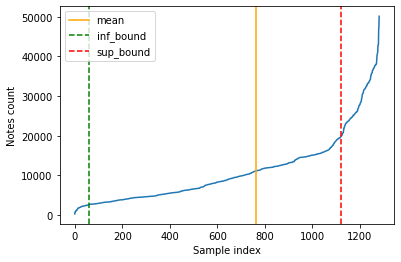

In [36]:
notes_count_mean = dataset.raw_notes_count.mean()
inf_bound = notes_count_mean - 1 * dataset.raw_notes_count.std()
sup_bound = notes_count_mean + 1 * dataset.raw_notes_count.std()

reduced_dataset = dataset[
    (dataset.raw_notes_count >= inf_bound) & (dataset.raw_notes_count <= sup_bound)
].copy()
display(reduced_dataset[["raw_notes_count"]].describe())

stats = pd.DataFrame(
    {"raw_notes_count": dataset.raw_notes_count.sort_values(ignore_index=True),}
)
plot = stats.plot(style={"inf_bound": "--", "sup_bound": "--"})
plot.set(xlabel='Sample index', ylabel='Notes count')

mean_index = stats.index[stats.raw_notes_count >= notes_count_mean][0]
inf_bound_index = stats.index[stats.raw_notes_count >= inf_bound][0]
sup_bound_index = stats.index[stats.raw_notes_count >= sup_bound][0]
mean_line = plot.axvline(x=mean_index, c="orange", label="mean")

# Draw separator lines for selected subset
inf_bound_line = plot.axvline(x=inf_bound_index, c="green", ls="--", label="inf_bound")
sup_bound_line = plot.axvline(x=sup_bound_index, c="red", ls="--", label="sup_bound")
plot.legend(handles=[mean_line, inf_bound_line, sup_bound_line])

# Extract stats for the notes counts
display(dataset[["raw_notes_count"]].describe())
display(stats)

In [64]:
max_notes_count = reduced_dataset.raw_notes_count.max()
min_notes_count = reduced_dataset.raw_notes_count.min()

def pad_array(a):
    return a[0:min_notes_count]

# Pad notes array to max length
reduced_dataset["padded_notes"] = reduced_dataset.raw_notes.swifter.apply(pad_array)

In [114]:
def format_data(data_to_format):
    train = data_to_format[data_to_format.split == 'train']
    test = data_to_format[data_to_format.split == 'test']
    validation = data_to_format[data_to_format.split == 'validation']
    x_split_train = np.vstack(train['padded_notes']).reshape(len(train.index), -1, FEATURES)
    y_split_train = np.asarray(train['canonical_composer'].cat.codes)
    x_split_test = np.vstack(test['padded_notes']).reshape(len(test.index), -1, FEATURES)
    y_split_test = np.asarray(test['canonical_composer'].cat.codes)
    x_split_validation = np.vstack(validation['padded_notes']).reshape(len(validation.index), -1, FEATURES)
    y_split_validation = np.asarray(validation['canonical_composer'].cat.codes)

    return x_split_train, y_split_train, x_split_test, y_split_test, x_split_validation, y_split_validation


NUM_CLASSES = number_of_classes(dataset)

In [126]:
x_train, y_train, x_test, y_test, x_validation, y_validation = format_data(reduced_dataset)
print(x_train[0].shape)
print(reduced_dataset['split'])
print(reduced_dataset['padded_notes'][0])
print(np.concatenate(x_train[0], axis=0))
print(reduced_dataset['canonical_composer'][0])
print((reduced_dataset['padded_notes'][0] == np.concatenate(x_train[0], axis=0)).all())
print(code_to_label(y_train[0]))

(2586, 1)
0            train
1            train
2            train
3            train
4       validation
           ...    
1275          test
1276          test
1279    validation
1280    validation
1281         train
Name: split, Length: 1061, dtype: category
Categories (3, object): ['test', 'train', 'validation']
[67 72 67 ... 94 60 48]
[67 72 67 ... 94 60 48]
Alban Berg
True
Alban Berg


In [116]:
def build_model(input_shape, output_shape):
    print(f'Input shape : {input_shape}')
    print(f'Output shape : {output_shape}')

    model_to_build = keras.Sequential(
        [
            keras.layers.Conv1D(filters=512, kernel_size=9, activation='relu', input_shape=input_shape),
            keras.layers.Flatten(),
            keras.layers.Dense(output_shape),
        ]
    )
    model_to_build.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_to_build.summary()
    return model_to_build

In [117]:
model = build_model(x_train[0].shape, NUM_CLASSES)

Input shape : (2586, 1)
Output shape : 61
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 2578, 512)         5120      
_________________________________________________________________
flatten_10 (Flatten)         (None, 1319936)           0         
_________________________________________________________________
dense_14 (Dense)             (None, 61)                80516157  
Total params: 80,521,277
Trainable params: 80,521,277
Non-trainable params: 0
_________________________________________________________________


In [43]:
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [120]:
checkpoint = keras.callbacks.ModelCheckpoint(f'./models/model.h5',
                                             monitor='val_accuracy', verbose=2,
                                             save_best_only=True, mode='max')
tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir='./logs/',
                                             profile_batch=(0, 32))

history = model.fit(x_train, y_train, batch_size=8, epochs=10,
#                    callbacks=[checkpoint],
                    validation_data=(x_test, y_test), use_multiprocessing=True)
loss, accuracy = model.evaluate(x_test, y_test, steps=10, use_multiprocessing=True)
print(f'Model has achieved {accuracy}% of accuracy with {loss} loss')

Epoch 1/10
100/100 [==============================] - 33s 331ms/step - loss: 14.4848 - accuracy: 0.0814 - val_loss: 14.9397 - val_accuracy: 0.0855
Epoch 2/10
100/100 [==============================] - 34s 339ms/step - loss: 14.6013 - accuracy: 0.0726 - val_loss: 14.8656 - val_accuracy: 0.0132
Epoch 3/10
100/100 [==============================] - 33s 334ms/step - loss: 14.5755 - accuracy: 0.0063 - val_loss: 14.7856 - val_accuracy: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 34s 338ms/step - loss: 14.5684 - accuracy: 0.0038 - val_loss: 14.7856 - val_accuracy: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 33s 329ms/step - loss: 14.5684 - accuracy: 0.0038 - val_loss: 14.7856 - val_accuracy: 0.0000e+00
Epoch 6/10
100/100 [==============================] - 33s 327ms/step - loss: 14.5684 - accuracy: 0.0038 - val_loss: 14.7856 - val_accuracy: 0.0000e+00
Epoch 7/10
100/100 [==============================] - 33s 332ms/step - loss: 14.5684 - accuracy: 0.003

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

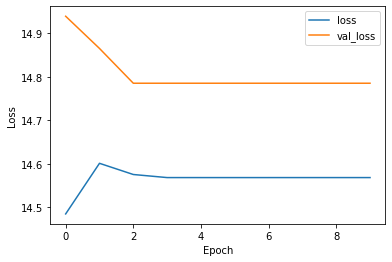

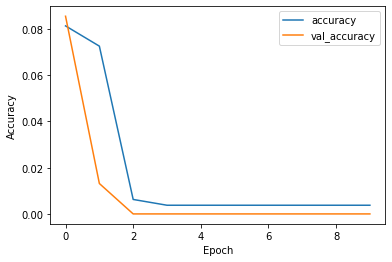

In [127]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot().set(xlabel="Epoch", ylabel="Loss")
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot().set(xlabel="Epoch", ylabel="Accuracy")

In [97]:
idx = np.random.choice(len(x_test))
sample, sample_label = x_test[idx], y_test[idx]

test_model = build_model(x_test[0].shape, NUM_CLASSES)
test_model.set_weights(model.get_weights())
result = tensorflow.argmax(test_model.predict_on_batch(tensorflow.expand_dims(sample, 0)), axis=1)
print(f'Predicted result is: {code_to_label(result)}, target result is: {code_to_label(sample_label)}, idx: {idx}')

Input shape : (19572, 1)
Output shape : 61
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 19570, 64)         256       
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 19568, 64)         12352     
_________________________________________________________________
dropout_25 (Dropout)         (None, 19568, 64)         0         
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 9784, 64)          0         
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 97, 64)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6208)              0         
_________________________________________________________________
dense_37 (